## Проект по теме "условная генерация изображений" 


Генерация изображений в стиле Studio Ghibli.        
Проект по созданию кастомной диффузионной модели с LoRA.

Подготовили: Посохова и Сергеева . 2025 год

все импорты в одном месте

In [1]:
import torch
print("PyTorch version:", torch.__version__) # должно быть 2.3.0+cu118
import os
import requests

from peft import LoraConfig, get_peft_model

from urllib.parse import urlparse
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
from transformers import CLIPTokenizer
import os
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
import random
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPTokenizer
import random
from PIL.Image import Resampling
from PIL import Image, ImageOps
from PIL import Image, ImageOps, ImageFilter
from transformers import CLIPTokenizer
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import UNet2DConditionModel, DDPMScheduler, StableDiffusionPipeline
from diffusers import AutoencoderKL
import torch
from torch import nn
import torch
torch.cuda.empty_cache()
import gc
from torch.optim import AdamW
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, StableDiffusionPipeline
from transformers import get_cosine_schedule_with_warmup

from peft import get_peft_model, LoraConfig
from torch.cuda.amp import GradScaler, autocast
import os
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler

from transformers import CLIPTextModel, CLIPTokenizer
from transformers import get_cosine_schedule_with_warmup

from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDPMScheduler,
    StableDiffusionPipeline,
)

from peft import get_peft_model, LoraConfig

import matplotlib.pyplot as plt  # для plot_loss()

PyTorch version: 2.3.0+cu118


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-05-24 08:07:33.331493: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 08:07:33.375359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-24 08:07:36.313996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Воровство картинок

с оффициального сайта студии Гибли для создания датасета из 250 картинок, по 50 из каждого мультфильма.      
 https://www.ghibli.jp/info/013772/

In [ ]:
def download_images(mov, start_pid, end_pid, output_dir="ghibli_images"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for pid in range(start_pid, end_pid + 1):
        pid = f"{pid:0{3}d}"
        img_url = f"https://www.ghibli.jp/gallery/{mov}{pid}.jpg"
        
        try:
            response = requests.get(img_url, stream=True)
            response.raise_for_status()
            
            # Определяем имя файла из URL
            parsed = urlparse(img_url)
            filename = os.path.basename(parsed.path)
            save_path = os.path.join(output_dir, filename)
            
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
                    
        except Exception as e:
            print(f"Ошибка при скачивании {img_url}: {e}")

movie_codes = ["mononoke","chihiro","kimitachi", "howl", "totoro"]


# Создание описания к картинкам

In [7]:

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    use_safetensors=True
).to(device)

image_folder = "ghibli_images"
output_file = "image_descriptions.txt"

In [6]:


with open(output_file, "w", encoding="utf-8") as f:
    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, filename)

            try:
                image = Image.open(image_path).convert("RGB")
                print(f"Processing: {filename}")

                inputs = processor(image, return_tensors="pt").to(device)

                # Генерируем несколько вариантов и выбираем лучший
                captions = []
                for _ in range(3):
                    out = model.generate(
                        **inputs,
                        do_sample=True,
                        temperature=0.9,
                        max_new_tokens=150,
                        top_k=50,
                        top_p=0.95,
                        no_repeat_ngram_size=3
                    )
                    caption = processor.decode(out[0], skip_special_tokens=True)
                    captions.append(caption)

                # Выбираем самую длинную версию как наиболее подробную
                best_caption = max(captions, key=len)

                # Добавляем текст про стиль Гибли это важно для обучения!!!
                best_caption_with_style = best_caption.strip()
                if not best_caption_with_style.lower().endswith("studio ghibli"):
                    best_caption_with_style += " in the style of Studio Ghibli"

                f.write(f"{filename}|{best_caption_with_style}\n")
                print(f"Success: {filename} -> {best_caption_with_style}")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

print(f" Descriptions saved to {output_file}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Processing: mononoke001.jpg
Success: mononoke001.jpg -> a couple of men sit on a tree next to an ose island in the style of Studio Ghibli
Processing: mononoke002.jpg
Success: mononoke002.jpg -> an animated animated scene of an actionable spider attacking a woman on a horse in the style of Studio Ghibli
Processing: mononoke003.jpg
Success: mononoke003.jpg -> a person holding up a bow and archery in the style of Studio Ghibli
Processing: mononoke004.jpg
Success: mononoke004.jpg -> an animation image of a woman wearing a red robe and holding a white hat while another plays guitar in the style of Studio Ghibli
Processing: mononoke005.jpg
Success: mononoke005.jpg -> anime character making face in their dressing room in the style of Studio Ghibli
Processing: mononoke006.jpg
Success: mononoke006.jpg -> a woman in a blue dress holding an arrow in front of a woman wearing a blue robe in the style of Studio Ghibli
Processing: mononoke007.jpg
Success: mononoke007.jpg -> a girl that is wearing red

## посмотрим на примеры изображений и подписей к ним

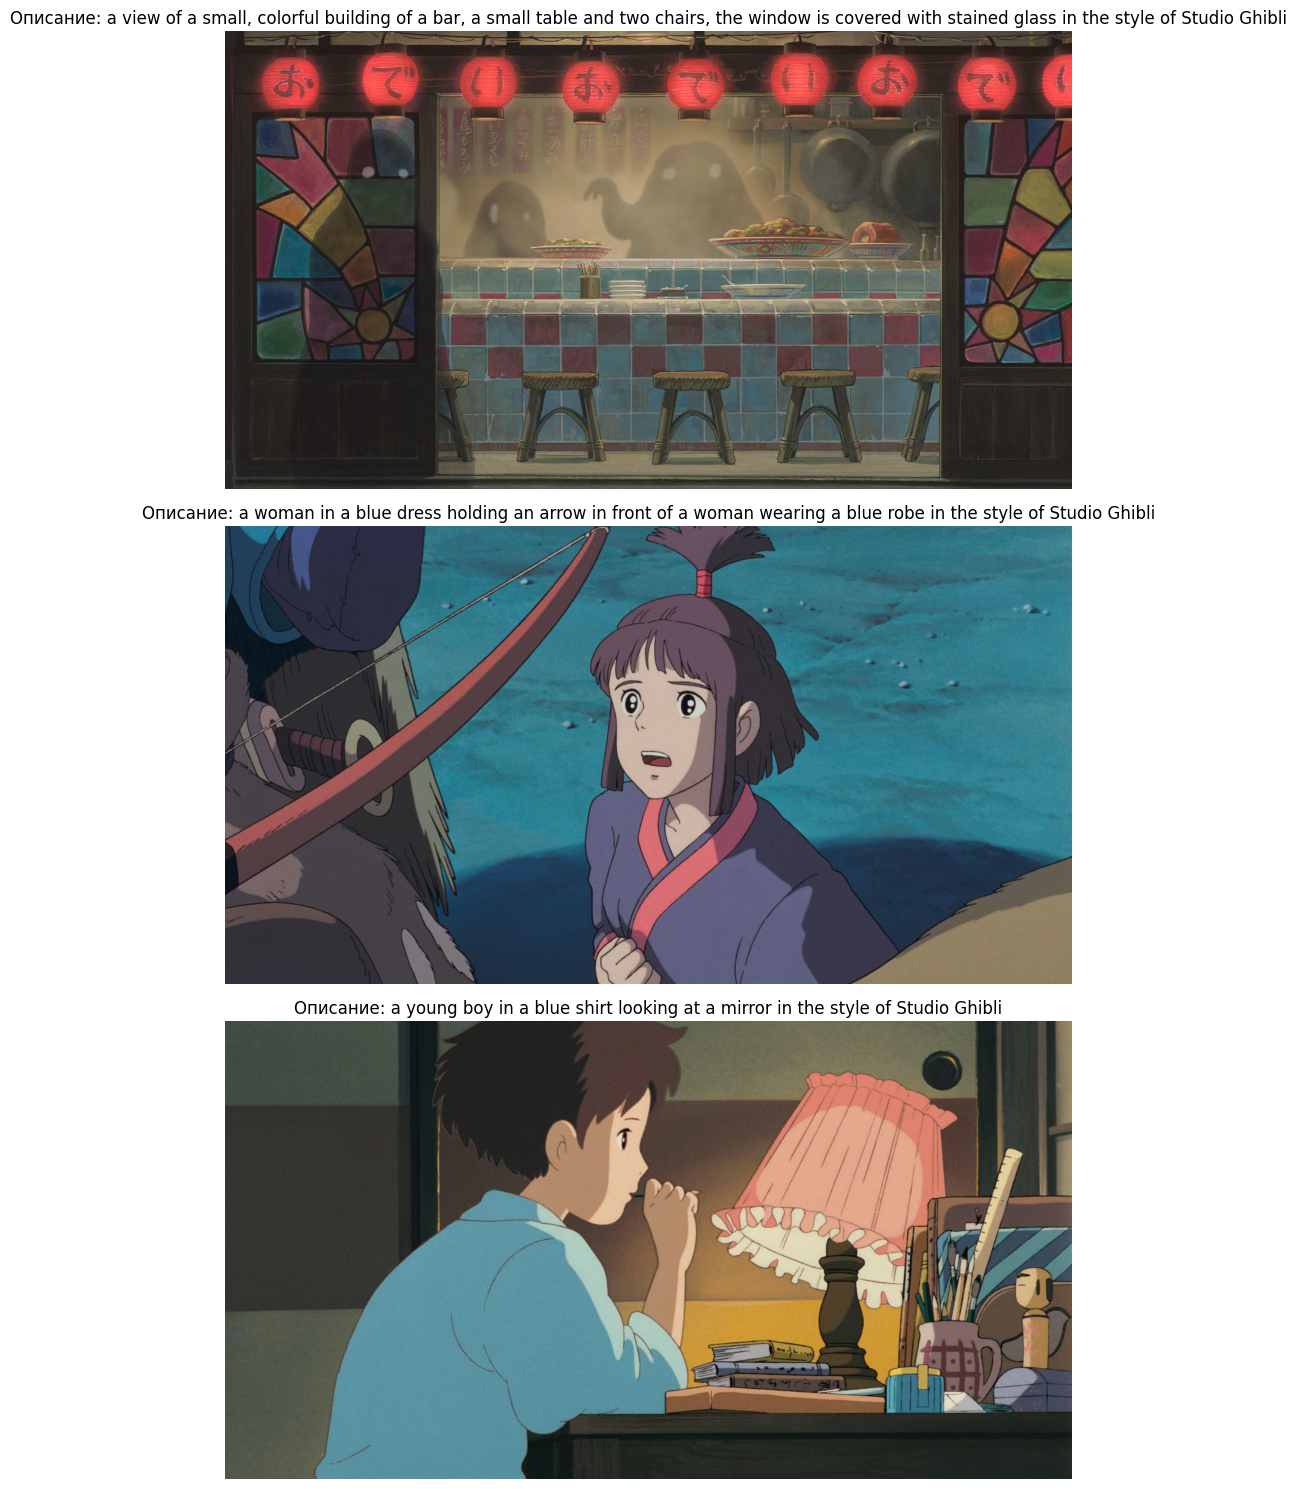

In [14]:

def show_examples(descriptions_file, image_folder, num_examples=3):
    with open(descriptions_file, "r", encoding="utf-8") as f:
        lines = f.readlines()
    
    examples = random.sample(lines, min(num_examples, len(lines)))
    
    plt.figure(figsize=(15, 5 * num_examples))
    
    for i, example in enumerate(examples, 1):
        filename, caption = example.strip().split("|", 1)
        image_path = os.path.join(image_folder, filename)
        
        try:
            img = Image.open(image_path)
            plt.subplot(num_examples, 1, i)
            plt.imshow(img)
            plt.title(f"Описание: {caption}", wrap=True)
            plt.axis('off')
            
        except Exception as e:
            print(f"Error displaying {filename}: {e}")
    
    plt.tight_layout()
    plt.show()

show_examples(output_file, image_folder, num_examples=3)

## Создаем возможность динамически редактировать подписи к изображениям с удобным интерфейсом

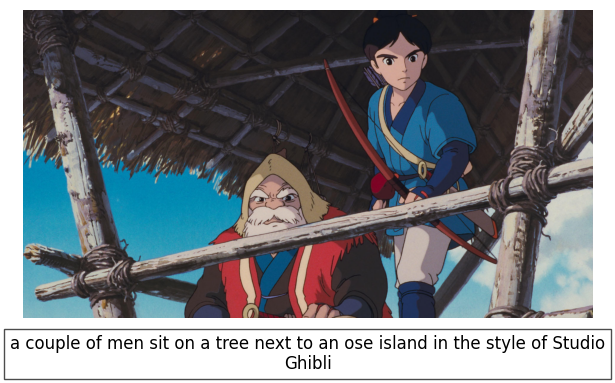


Изображение 1/250
Файл: mononoke001.jpg
Описание: a couple of men sit on a tree next to an ose island in the style of Studio Ghibli

1. Следующее изображение
2. Предыдущее изображение
3. Редактировать описание
4. Сохранить и выйти



Выберите действие (1-4):  4



Изменения сохранены. Выход...


In [13]:

image_folder = "ghibli_images"
output_file = "image_descriptions.txt"

def load_descriptions():
    """Загрузка описаний из файла"""
    descriptions = {}
    if os.path.exists(output_file):
        with open(output_file, "r", encoding="utf-8") as f:
            for line in f:
                if "|" in line:
                    filename, caption = line.strip().split("|", 1)
                    descriptions[filename] = caption
    return descriptions

def save_descriptions(descriptions):
    """Сохранение описаний в файл"""
    with open(output_file, "w", encoding="utf-8") as f:
        for fn, cap in descriptions.items():
            f.write(f"{fn}|{cap}\n")

def show_edit_menu(current_caption):
    """Меню редактирования описания"""
    print("\nТекущее описание:")
    print("-" * 50)
    print(current_caption)
    print("-" * 50)
    return input("Введите новое описание (или нажмите Enter чтобы оставить как есть): ").strip() or current_caption
        
def display_image(image_path, caption):
    """Отображение изображения с подписью"""
    img = Image.open(image_path)
    
    # Создаем новое окно для каждого изображения
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.axis('off')
    
    # Добавляем текст описания
    plt.figtext(0.5, 0.05, caption if caption else "[Описание отсутствует]", 
               wrap=True, 
               horizontalalignment='center',
               fontsize=12,
               bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show(block=False)  # Не блокируем выполнение кода
    plt.pause(0.1)  # Короткая пауза для отображения

def main():
    descriptions = load_descriptions()
    image_files = [f for f in os.listdir(image_folder) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print("В папке нет изображений!")
        return
    
    current_index = 0
    
    while True:
        filename = image_files[current_index]
        image_path = os.path.join(image_folder, filename)
        caption = descriptions.get(filename, "")
        
        # Отображаем новое изображение
        display_image(image_path, caption)
        
        # Информация о текущем изображении
        print(f"\nИзображение {current_index + 1}/{len(image_files)}")
        print(f"Файл: {filename}")
        print(f"Описание: {caption}")
        
        # Основное меню
        print("\n1. Следующее изображение")
        print("2. Предыдущее изображение")
        print("3. Редактировать описание")
        print("4. Сохранить и выйти")
        
        choice = input("\nВыберите действие (1-4): ")
        
        if choice == "1":
            current_index = (current_index + 1) % len(image_files)
        elif choice == "2":
            current_index = (current_index - 1) % len(image_files)
        elif choice == "3":
            descriptions[filename] = show_edit_menu(caption)
        elif choice == "4":
            save_descriptions(descriptions)
            plt.close('all')  # Закрываем все изображения перед выходом
            print("\nИзменения сохранены. Выход...")
            break

if __name__ == "__main__":
    main()
    

# Подготовка

## тут  мы тестили разные ресайзы, чтобы выбрать оптимальный. а еще тут же размер батча ставится и добавляется токен гибли 

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Обработано 250 изображений
Пример: mononoke001.jpg


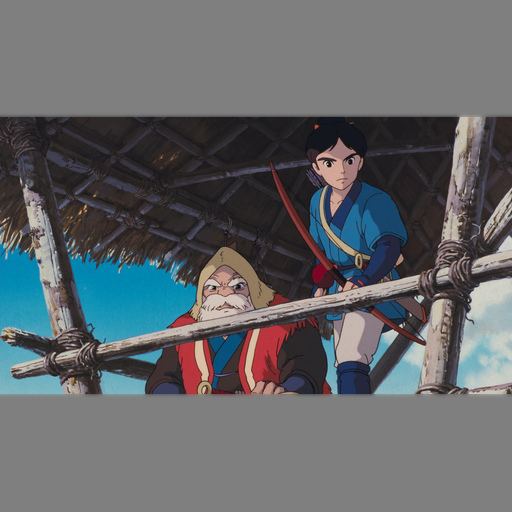

Пример: mononoke002.jpg


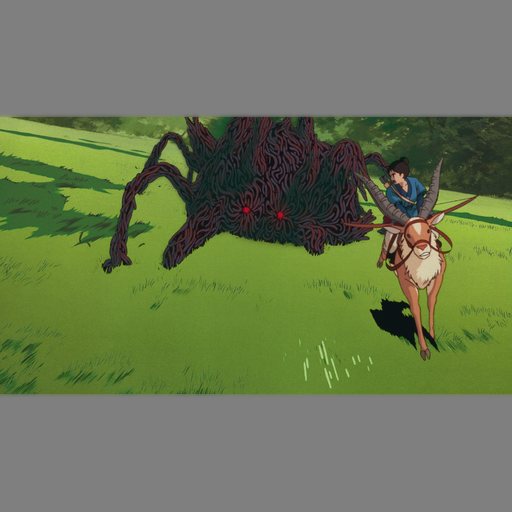

Пример: mononoke003.jpg


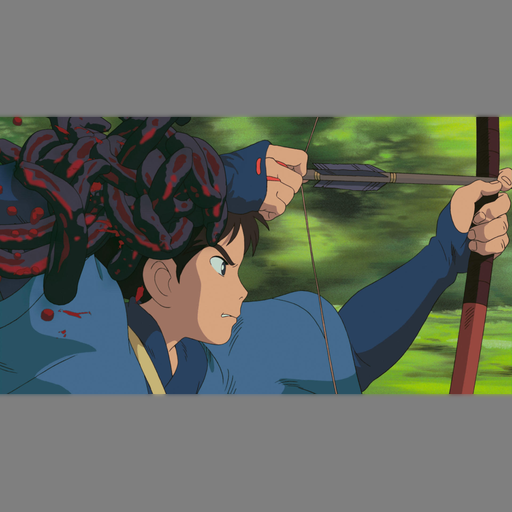

Пример промпта: a couple of men sit on a tree next to an ose island in the style of Studio Ghibli
Загружено 250 изображений с описаниями

Проверка батча:
Размер pixel_values: torch.Size([1, 3, 512, 512])
Размер input_ids: torch.Size([1, 77])
Пример input_ids: tensor([49406,   283, 40555,   285,   320,  1611,   530,   320,  1746,  2595,
         7286,   320,  8960,   530,   899,  1155,  2463,   530,   518,  1844,
          539,  3155, 40555, 49407,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])
Соответствующий текст: <|startoftext|>< ghibli > a girl in a blue dress holds a knife in her right hand in the style of studio ghibli <|

In [1]:

image_dir = "ghibli_images"
output_dir = "processed_ghibli"
os.makedirs(output_dir, exist_ok=True)

def resize_and_pad(image, size=(512, 512), blur_radius=2):
    image = image.convert("RGB")
    image.thumbnail(size, Resampling.LANCZOS)

    delta_w = size[0] - image.width
    delta_h = size[1] - image.height
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)

    # создаём фон с тем же цветом, что и среднее изображение
    background = Image.new("RGB", size, color=(127, 127, 127))
    
    # вставляем изображение в центр
    background.paste(image, (padding[0], padding[1]))

    # накладываем размытие на весь фон
    blurred = background.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    # и снова вставляем оригинал в центр поверх размытия
    blurred.paste(image, (padding[0], padding[1]))

    return blurred

processed_images = []

for i, img_name in enumerate(os.listdir(image_dir)):
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(image_dir, img_name)
        image = Image.open(img_path)
        image = resize_and_pad(image, size=(512, 512))
        image.save(os.path.join(output_dir, img_name))

        if i < 3:
            processed_images.append((img_name, image))

print(f"Обработано {len(os.listdir(output_dir))} изображений")

# Вывод 3 примеров
for name, img in processed_images:
    print(f"Пример: {name}")
    display(img)

# 2. Загрузка описаний
with open("image_descriptions.txt", "r", encoding="utf-8") as f:
    captions = {line.split("|")[0]: line.split("|")[1].strip() for line in f.readlines()}

print("Пример промпта:", captions[list(captions.keys())[0]])

# 3. Инициализация токенизатора
tokenizer = CLIPTokenizer.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    subfolder="tokenizer"
)

# 4. Определение преобразований с цветокоррекцией
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
])

# 5. Класс датасета
class GhibliDataset(Dataset):
    def __init__(self, image_dir, captions, transform=None):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.captions = captions
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        filename = os.path.basename(image_path)
        caption = self.captions.get(filename, "")

        if self.transform:
            image = self.transform(image)

        return {"pixel_values": image, "caption": caption}

# 6. Создание датасета
dataset = GhibliDataset(output_dir, captions, transform=image_transforms)
print(f"Загружено {len(dataset)} изображений с описаниями")

# 7. Функция для создания батчей
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    
    # Добавим <ghibli> в начало каждого caption'а
    captions = [f"<ghibli> {item['caption'].strip()}" for item in batch]

    inputs = tokenizer(
        captions,
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt"
    )
    return {
        "pixel_values": pixel_values,
        "input_ids": inputs.input_ids,
        "attention_mask": inputs.attention_mask
    }
# 8. Создание DataLoader
BATCH_SIZE = 1
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

# 9. Проверка батча
sample_batch = next(iter(dataloader))
print("\nПроверка батча:")
print("Размер pixel_values:", sample_batch["pixel_values"].shape)
print("Размер input_ids:", sample_batch["input_ids"].shape)
print("Пример input_ids:", sample_batch["input_ids"][0])
print("Соответствующий текст:", tokenizer.decode(sample_batch["input_ids"][0]))

VAE загружается и замораживается (без обучения).

UNet загружается и к нему применяется LoRA с параметрами r=8, lora_alpha=16.

Текстовый энкодер загружается, но НЕ обучается (параметры в оптимизатор не попали).

Оптимизатор и scheduler:

Обучаются только LoRA-параметры UNet.

Используется cosine scheduler с warmup 10% от общего числа шагов.

Обучающий цикл:

Токенизированный текст берется из батча.

Изображение кодируется в латентное пространство.

Добавляется шум.

Предсказывается шум UNet-ом с помощью эмбеддингов текста.

Вычисляется MSE loss, обновляются параметры.

В конце каждой эпохи выводится средний лосс.

Сохранение LoRA:

После обучения LoRA веса UNet сохраняются в папку lora_ghibli.

## важный код


In [13]:
# --- Константы и устройство ---
MODEL_ID = "stabilityai/stable-diffusion-2-1-base"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
epoxs  = 4

In [ ]:
# --- Токенизатор с добавлением нового токена ---
tokenizer = CLIPTokenizer.from_pretrained(MODEL_ID, subfolder="tokenizer")
tokenizer.add_tokens(["<ghibli>"])
print(f"Новый размер словаря: {len(tokenizer)}")

In [ ]:
text_encoder = CLIPTextModel.from_pretrained(MODEL_ID, subfolder="text_encoder").to(DEVICE)
text_encoder.resize_token_embeddings(len(tokenizer))

vae = AutoencoderKL.from_pretrained(MODEL_ID, subfolder="vae").to(DEVICE)
vae.requires_grad_(False)

unet = UNet2DConditionModel.from_pretrained(MODEL_ID, subfolder="unet").to(DEVICE)
unet.set_attention_slice("auto")

In [ ]:
# LoRA 
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.1,
    bias="none"
)
unet_lora = get_peft_model(unet, lora_config)

Новый размер словаря: 49409


Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 97.85it/s]


Epoch 1 loss: 0.0707
Epoch 2 loss: 0.0650
Epoch 3 loss: 0.0708
Epoch 4 loss: 0.0753
LoRA сохранена!


100%|██████████| 40/40 [00:09<00:00,  4.17it/s]


Сохранено: generated_images/epoch_final.png


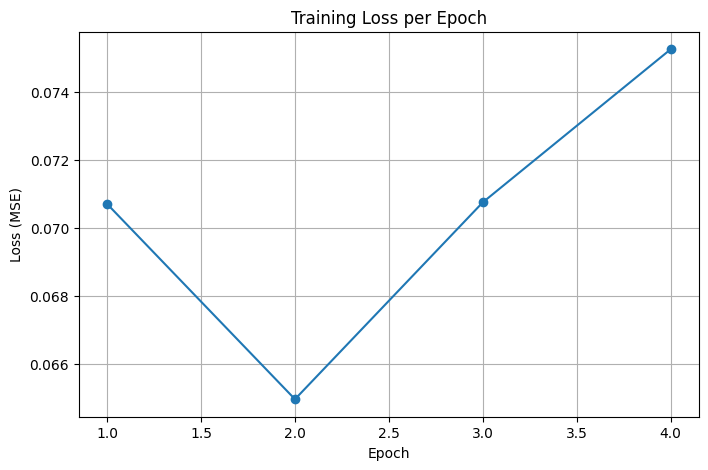

In [27]:

# --- Оптимизатор 
optimizer = AdamW([
    {"params": unet_lora.parameters()},
    {"params": text_encoder.get_input_embeddings().parameters()}
], lr=2e-5)


train_steps = len(dataloader) * epoxs # 5 эпох
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, int(0.1 * train_steps), train_steps)

noise_scheduler = DDPMScheduler.from_pretrained(MODEL_ID, subfolder="scheduler")

scaler = GradScaler()

# --- Пайплайн генерации (без LoRA) 
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    text_encoder=text_encoder,
    vae=vae,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
    torch_dtype=torch.float16,
).to(DEVICE)
pipe.enable_attention_slicing()

def generate_image(prompt, step=None):
    pipe.unet.eval()
    pipe.text_encoder.eval()
    pipe.vae.eval()
    with torch.no_grad():
        image = pipe(prompt, num_inference_steps=40, guidance_scale=7.5).images[0]
    os.makedirs("generated_images", exist_ok=True)
    img_path = f"generated_images/epoch_{step}.png"
    image.save(img_path)
    print(f"Сохранено: {img_path}")
    torch.cuda.empty_cache()
    return image


def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

def train(unet_lora, dataloader):
    unet_lora.enable_gradient_checkpointing()
    loss_history = []

    train_steps = len(dataloader) * epoxs
    lr_scheduler = get_cosine_schedule_with_warmup(optimizer, int(0.1 * train_steps), train_steps)

    for epoch in range(epoxs):
        unet_lora.train()
        text_encoder.train()
        total_loss = 0.0

        for batch in dataloader:
            pixel_values = batch["pixel_values"].to(DEVICE)
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)

            with torch.no_grad():
                latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor

            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (latents.size(0),), device=DEVICE
            ).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            encoder_hidden_states = text_encoder(input_ids, attention_mask=attention_mask)[0]

            optimizer.zero_grad()
            with autocast():
                noise_pred = unet_lora(noisy_latents, timesteps, encoder_hidden_states).sample
                loss = F.mse_loss(noise_pred, noise)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()
            total_loss += loss.item()

            del pixel_values, input_ids, attention_mask, latents, noise
            del timesteps, noisy_latents, encoder_hidden_states, noise_pred, loss
            clear_gpu()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch + 1} loss: {avg_loss:.4f}")

        unet_merged = unet_lora.merge_and_unload()
        pipe.unet = unet_merged

        base_unet = UNet2DConditionModel.from_pretrained(MODEL_ID, subfolder="unet").to(DEVICE)
        base_unet.set_attention_slice("auto")
        unet_lora = get_peft_model(base_unet, lora_config)
        unet_lora.load_adapter("lora_ghibli", adapter_name="default")
        pipe.unet = unet_lora
        clear_gpu()

    unet_lora.save_pretrained("lora_ghibli")
    print("LoRA сохранена!")

    pipe.unet = unet_lora.merge_and_unload()
    generate_image("a boy with a bouquet of flowers in <ghibli> style", step="final")
    clear_gpu()

    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker="o")
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.grid(True)
    plt.show()



train(unet_lora, dataloader)





## ГЕНЕРАЦИЯ ИЗОБРАЖЕНИЯ

In [26]:

base_unet = UNet2DConditionModel.from_pretrained(MODEL_ID, subfolder="unet").to(DEVICE)

# Повторно создаём конфигурацию LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.1,
    bias="none"
)

# Оборачиваем базовый UNet в LoRA и загружаем адаптер
unet_with_lora = get_peft_model(base_unet, lora_config)
unet_with_lora.load_adapter("lora_ghibli", "default")

# Обновляем пайплайн
pipe.unet = unet_with_lora

try:
    pipe.fuse_lora(lora_scale=0.6)
    print("LoRA успешно встроена с масштабом 0.6")
except Exception as e:
    print(f"Ошибка при слиянии LoRA: {e}")
    raise

# Переводим все модули в float16
pipe.unet = pipe.unet.to(dtype=torch.float16)
pipe.text_encoder = pipe.text_encoder.to(dtype=torch.float16)
pipe.vae = pipe.vae.to(dtype=torch.float16)

# Проверка
print("UNet dtype:", next(pipe.unet.parameters()).dtype)
print("Text Encoder dtype:", next(pipe.text_encoder.parameters()).dtype)
print("VAE dtype:", next(pipe.vae.parameters()).dtype)

# Генерация изображения
generate_image("a girl with bright lights in the style of <Ghibli>", step="fused_final")

torch.cuda.empty_cache()

LoRA успешно встроена с масштабом 0.6
UNet dtype: torch.float16
Text Encoder dtype: torch.float16
VAE dtype: torch.float16


100%|██████████| 40/40 [00:02<00:00, 16.43it/s]


Сохранено: generated_images/epoch_fused_final.png
